In [1]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle competitions download -c facial-keypoints-detection

 75% 57.0M/76.3M [00:00<00:00, 91.8MB/s]
100% 76.3M/76.3M [00:00<00:00, 114MB/s] 


In [4]:
!unzip facial-keypoints-detection

Archive:  facial-keypoints-detection.zip
  inflating: IdLookupTable.csv       
  inflating: SampleSubmission.csv    
  inflating: test.zip                
  inflating: training.zip            


In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
import cv2
import glob as gb
import zipfile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping  

In [29]:
with zipfile.ZipFile('training.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

with zipfile.ZipFile('test.zip', 'r') as zip_ref:
    zip_ref.extractall('data')


In [33]:
# Load the training dataset into memory
train_data = pd.read_csv('data/training.csv')
train_data.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


In [34]:

# test data
test_data = pd.read_csv('data/test.csv')
test_data.head()


,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


In [38]:
train_data.shape

(7049, 31)

In [35]:

# check the number of missing values
train_data.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

In [39]:

# using ffill to fill the missing values
train_data.fillna(method='ffill', inplace=True)

In [40]:
# check the number of missing values
train_data.isnull().sum()

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
left_eye_inner_corner_x      0
left_eye_inner_corner_y      0
left_eye_outer_corner_x      0
left_eye_outer_corner_y      0
right_eye_inner_corner_x     0
right_eye_inner_corner_y     0
right_eye_outer_corner_x     0
right_eye_outer_corner_y     0
left_eyebrow_inner_end_x     0
left_eyebrow_inner_end_y     0
left_eyebrow_outer_end_x     0
left_eyebrow_outer_end_y     0
right_eyebrow_inner_end_x    0
right_eyebrow_inner_end_y    0
right_eyebrow_outer_end_x    0
right_eyebrow_outer_end_y    0
nose_tip_x                   0
nose_tip_y                   0
mouth_left_corner_x          0
mouth_left_corner_y          0
mouth_right_corner_x         0
mouth_right_corner_y         0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
Image                        0
dtype: int64

In [44]:

## Analysis of the Images
# %%
im_width, im_height = 96, 96

# %%
# checking the data type of the image column
type(train_data['Image'][0])

str

In [45]:

# convert the image column to numpy array
train_data['Image'] = train_data['Image'].apply(lambda x: np.fromstring(x, sep=' '))

In [46]:

img = []

for i in range(0, 7049):
    img_pixel = train_data['Image'][i].reshape(im_width, im_height)
    img.append(img_pixel)

# %%
# convert the list to numpy array
img = np.array(img)

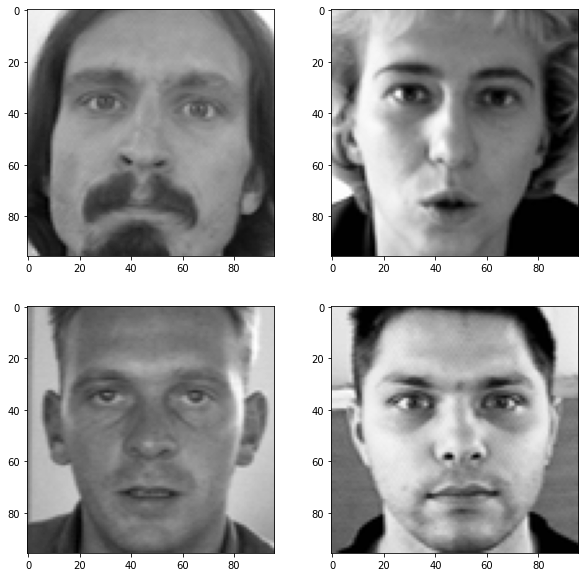

In [48]:

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(img[0], cmap='gray')
ax[0, 1].imshow(img[1], cmap='gray')
ax[1, 0].imshow(img[2], cmap='gray')
ax[1, 1].imshow(img[3], cmap='gray')

In [50]:

from sklearn.model_selection import train_test_split

In [51]:

# separate the features and labels
X = img
y = train_data.drop(['Image'], axis=1)

# %%
# split the data into training and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# %%
# convert the data to float32
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

# %%
# normalize the data
X_train /= 255
X_val /= 255

# %%
# reshape the data
X_train = X_train.reshape(-1, 96, 96, 1)
X_val = X_val.reshape(-1, 96, 96, 1)

In [52]:

# check the shape of the data
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((5639, 96, 96, 1), (1410, 96, 96, 1), (5639, 30), (1410, 30))

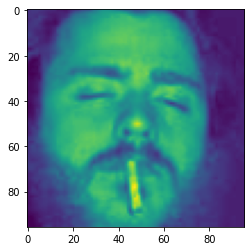

In [54]:
plt.imshow(X_train[1500])
plt.show()

In [57]:
import random

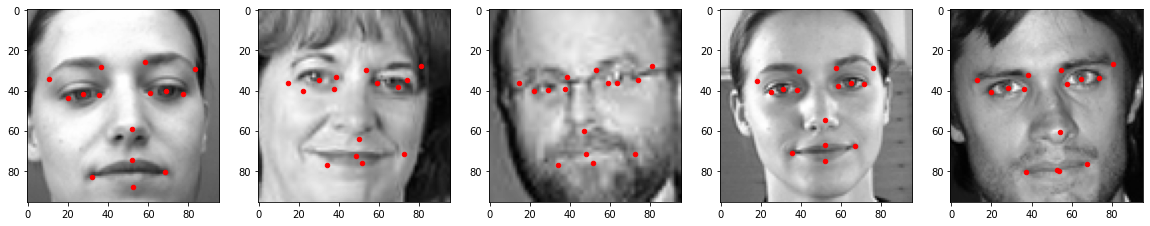

In [60]:
# face keypoints
def show_keypoints(image, keypoints):
    plt.imshow(image, cmap='gray')
    plt.scatter(keypoints[0::2], keypoints[1::2], marker='o', s=20, c='r')

# %%
plt.figure(figsize=(20, 10))
for i in range(0, 5):
    plt.subplot(1, 5, i+1)
    show_keypoints(X_train[i], y_train.iloc[i])



In [61]:

# define the model
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dense(30)
])

# %%
# compile the model
model.compile(optimizer='adam',
                loss='mean_squared_error',          
                metrics=['mae'])

# %%
# define the callbacks
checkpoint = ModelCheckpoint('model-{epoch:03d}.model', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')


In [67]:
# train the model
history = model.fit(X_train, y_train, epochs=100, callbacks=[checkpoint, earlystop], validation_data=(X_val, y_val))

Epoch 1/100
177/177 [==============================] - 70s 389ms/step - loss: 13.0038 - mae: 2.4894 - val_loss: 17.4754 - val_mae: 3.1797
Epoch 2/100
177/177 [==============================] - 69s 392ms/step - loss: 13.3763 - mae: 2.5612 - val_loss: 9.8422 - val_mae: 1.9221
Epoch 3/100
177/177 [==============================] - 69s 392ms/step - loss: 12.9125 - mae: 2.4827 - val_loss: 10.2744 - val_mae: 2.0964
Epoch 4/100
177/177 [==============================] - 69s 391ms/step - loss: 12.7964 - mae: 2.4718 - val_loss: 10.1633 - val_mae: 2.1427
Epoch 5/100
177/177 [==============================] - 70s 394ms/step - loss: 12.8434 - mae: 2.4813 - val_loss: 10.8518 - val_mae: 2.3198
Epoch 6/100
177/177 [==============================] - 69s 388ms/step - loss: 12.3727 - mae: 2.4139 - val_loss: 10.3116 - val_mae: 2.1448
Epoch 7/100
177/177 [==============================] - ETA: 0s - loss: 13.6525 - mae: 2.5734

177/177 [==============================] - 70s 396ms/step - loss: 13.6525 - mae: 2.5734 - val_loss: 9.5000 - val_mae: 1.9502
Epoch 8/100
177/177 [==============================] - 69s 391ms/step - loss: 12.2152 - mae: 2.3946 - val_loss: 11.5852 - val_mae: 2.3075
Epoch 9/100
177/177 [==============================] - ETA: 0s - loss: 12.0221 - mae: 2.3744

177/177 [==============================] - 70s 399ms/step - loss: 12.0221 - mae: 2.3744 - val_loss: 9.3974 - val_mae: 1.9653
Epoch 10/100
177/177 [==============================] - 70s 395ms/step - loss: 12.3227 - mae: 2.4120 - val_loss: 11.9347 - val_mae: 2.5063
Epoch 11/100
177/177 [==============================] - 69s 389ms/step - loss: 12.6156 - mae: 2.4691 - val_loss: 9.5492 - val_mae: 2.0023
Epoch 12/100
177/177 [==============================] - 69s 388ms/step - loss: 12.0693 - mae: 2.3788 - val_loss: 9.8170 - val_mae: 2.0662
Epoch 13/100
177/177 [==============================] - 69s 392ms/step - loss: 12.1817 - mae: 2.4041 - val_loss: 11.4801 - val_mae: 2.2422
Epoch 14/100
177/177 [==============================] - ETA: 0s - loss: 11.7601 - mae: 2.3320

177/177 [==============================] - 70s 397ms/step - loss: 11.7601 - mae: 2.3320 - val_loss: 9.1662 - val_mae: 1.8395
Epoch 15/100
177/177 [==============================] - ETA: 0s - loss: 11.7860 - mae: 2.3442

177/177 [==============================] - 70s 399ms/step - loss: 11.7860 - mae: 2.3442 - val_loss: 9.0701 - val_mae: 1.8601
Epoch 16/100
177/177 [==============================] - ETA: 0s - loss: 11.5201 - mae: 2.3177

177/177 [==============================] - 71s 399ms/step - loss: 11.5201 - mae: 2.3177 - val_loss: 8.9930 - val_mae: 1.8747
Epoch 17/100
177/177 [==============================] - 68s 386ms/step - loss: 12.0864 - mae: 2.3928 - val_loss: 9.2312 - val_mae: 1.8564
Epoch 18/100
177/177 [==============================] - 69s 392ms/step - loss: 11.5376 - mae: 2.3155 - val_loss: 9.1084 - val_mae: 1.9206
Epoch 19/100
177/177 [==============================] - ETA: 0s - loss: 11.7070 - mae: 2.3425

177/177 [==============================] - 71s 402ms/step - loss: 11.7070 - mae: 2.3425 - val_loss: 8.8958 - val_mae: 1.8847
Epoch 20/100
177/177 [==============================] - ETA: 0s - loss: 11.4677 - mae: 2.3132

177/177 [==============================] - 72s 406ms/step - loss: 11.4677 - mae: 2.3132 - val_loss: 8.7294 - val_mae: 1.8406
Epoch 21/100
177/177 [==============================] - 69s 390ms/step - loss: 11.1502 - mae: 2.2874 - val_loss: 9.9651 - val_mae: 2.0816
Epoch 22/100
177/177 [==============================] - ETA: 0s - loss: 11.2255 - mae: 2.2968

177/177 [==============================] - 71s 400ms/step - loss: 11.2255 - mae: 2.2968 - val_loss: 8.5357 - val_mae: 1.8715
Epoch 23/100
177/177 [==============================] - 69s 388ms/step - loss: 10.9529 - mae: 2.2602 - val_loss: 8.8198 - val_mae: 1.9928
Epoch 24/100
177/177 [==============================] - ETA: 0s - loss: 10.9740 - mae: 2.2760

177/177 [==============================] - 70s 396ms/step - loss: 10.9740 - mae: 2.2760 - val_loss: 8.0502 - val_mae: 1.7571
Epoch 25/100
177/177 [==============================] - ETA: 0s - loss: 10.5572 - mae: 2.2280

177/177 [==============================] - 71s 401ms/step - loss: 10.5572 - mae: 2.2280 - val_loss: 8.0280 - val_mae: 1.8344
Epoch 26/100
177/177 [==============================] - ETA: 0s - loss: 10.2265 - mae: 2.1913

177/177 [==============================] - 73s 412ms/step - loss: 10.2265 - mae: 2.1913 - val_loss: 7.4583 - val_mae: 1.6383
Epoch 27/100
177/177 [==============================] - 71s 399ms/step - loss: 10.0493 - mae: 2.1798 - val_loss: 7.9303 - val_mae: 1.8298
Epoch 28/100
177/177 [==============================] - ETA: 0s - loss: 10.0250 - mae: 2.1942

177/177 [==============================] - 70s 395ms/step - loss: 10.0250 - mae: 2.1942 - val_loss: 6.9550 - val_mae: 1.6346
Epoch 29/100
177/177 [==============================] - 69s 390ms/step - loss: 9.5922 - mae: 2.1150 - val_loss: 7.1445 - val_mae: 1.7235
Epoch 30/100
177/177 [==============================] - ETA: 0s - loss: 9.8741 - mae: 2.1786

177/177 [==============================] - 71s 400ms/step - loss: 9.8741 - mae: 2.1786 - val_loss: 6.7887 - val_mae: 1.5878
Epoch 31/100
177/177 [==============================] - 69s 392ms/step - loss: 9.3933 - mae: 2.0957 - val_loss: 6.9236 - val_mae: 1.6316
Epoch 32/100
177/177 [==============================] - ETA: 0s - loss: 9.4187 - mae: 2.1207

177/177 [==============================] - 69s 391ms/step - loss: 9.4187 - mae: 2.1207 - val_loss: 6.7662 - val_mae: 1.5312
Epoch 33/100
177/177 [==============================] - 69s 390ms/step - loss: 9.3651 - mae: 2.1089 - val_loss: 8.4734 - val_mae: 2.0268
Epoch 34/100
177/177 [==============================] - ETA: 0s - loss: 9.2055 - mae: 2.0991

177/177 [==============================] - 71s 401ms/step - loss: 9.2055 - mae: 2.0991 - val_loss: 6.0613 - val_mae: 1.4646
Epoch 35/100
177/177 [==============================] - 69s 390ms/step - loss: 8.7000 - mae: 2.0252 - val_loss: 6.4615 - val_mae: 1.5783
Epoch 36/100
177/177 [==============================] - ETA: 0s - loss: 8.8040 - mae: 2.0426

177/177 [==============================] - 70s 397ms/step - loss: 8.8040 - mae: 2.0426 - val_loss: 5.9352 - val_mae: 1.4439
Epoch 37/100
177/177 [==============================] - ETA: 0s - loss: 8.5871 - mae: 2.0024

177/177 [==============================] - 70s 396ms/step - loss: 8.5871 - mae: 2.0024 - val_loss: 5.7985 - val_mae: 1.4535
Epoch 38/100
177/177 [==============================] - 69s 391ms/step - loss: 8.4050 - mae: 1.9952 - val_loss: 6.2737 - val_mae: 1.5705
Epoch 39/100
177/177 [==============================] - ETA: 0s - loss: 8.4012 - mae: 1.9979

177/177 [==============================] - 70s 396ms/step - loss: 8.4012 - mae: 1.9979 - val_loss: 5.6835 - val_mae: 1.4416
Epoch 40/100
177/177 [==============================] - 69s 390ms/step - loss: 8.7167 - mae: 2.0382 - val_loss: 8.6122 - val_mae: 2.1734
Epoch 41/100
177/177 [==============================] - ETA: 0s - loss: 8.3875 - mae: 2.0052

177/177 [==============================] - 70s 396ms/step - loss: 8.3875 - mae: 2.0052 - val_loss: 5.6390 - val_mae: 1.4304
Epoch 42/100
177/177 [==============================] - ETA: 0s - loss: 8.3544 - mae: 1.9932

177/177 [==============================] - 70s 394ms/step - loss: 8.3544 - mae: 1.9932 - val_loss: 5.4010 - val_mae: 1.3949
Epoch 43/100
177/177 [==============================] - 68s 383ms/step - loss: 8.2157 - mae: 1.9791 - val_loss: 5.5629 - val_mae: 1.3874
Epoch 44/100
177/177 [==============================] - ETA: 0s - loss: 7.9834 - mae: 1.9440

177/177 [==============================] - 70s 394ms/step - loss: 7.9834 - mae: 1.9440 - val_loss: 5.3761 - val_mae: 1.4467
Epoch 45/100
177/177 [==============================] - 69s 388ms/step - loss: 7.8740 - mae: 1.9373 - val_loss: 6.0064 - val_mae: 1.6092
Epoch 46/100
177/177 [==============================] - 69s 389ms/step - loss: 7.9614 - mae: 1.9438 - val_loss: 5.5464 - val_mae: 1.4488
Epoch 47/100
177/177 [==============================] - 69s 388ms/step - loss: 7.6414 - mae: 1.8981 - val_loss: 5.7051 - val_mae: 1.5401
Epoch 48/100
177/177 [==============================] - 70s 392ms/step - loss: 7.4869 - mae: 1.8757 - val_loss: 5.5386 - val_mae: 1.4682
Epoch 49/100
177/177 [==============================] - 69s 388ms/step - loss: 7.5790 - mae: 1.8959 - val_loss: 5.6815 - val_mae: 1.5135
Epoch 50/100
177/177 [==============================] - ETA: 0s - loss: 7.1868 - mae: 1.8320

177/177 [==============================] - 71s 402ms/step - loss: 7.1868 - mae: 1.8320 - val_loss: 5.1734 - val_mae: 1.3939
Epoch 51/100
177/177 [==============================] - ETA: 0s - loss: 7.2557 - mae: 1.8497

177/177 [==============================] - 70s 395ms/step - loss: 7.2557 - mae: 1.8497 - val_loss: 5.0608 - val_mae: 1.4030
Epoch 52/100
177/177 [==============================] - 69s 389ms/step - loss: 7.2089 - mae: 1.8488 - val_loss: 5.1781 - val_mae: 1.4180
Epoch 53/100
177/177 [==============================] - ETA: 0s - loss: 7.0114 - mae: 1.8191

177/177 [==============================] - 69s 392ms/step - loss: 7.0114 - mae: 1.8191 - val_loss: 4.9389 - val_mae: 1.3310
Epoch 54/100
177/177 [==============================] - ETA: 0s - loss: 6.8396 - mae: 1.8055

177/177 [==============================] - 70s 394ms/step - loss: 6.8396 - mae: 1.8055 - val_loss: 4.9135 - val_mae: 1.3523
Epoch 55/100
177/177 [==============================] - 69s 388ms/step - loss: 7.0145 - mae: 1.8257 - val_loss: 5.0112 - val_mae: 1.3664
Epoch 56/100
177/177 [==============================] - ETA: 0s - loss: 6.7754 - mae: 1.7871

177/177 [==============================] - 71s 399ms/step - loss: 6.7754 - mae: 1.7871 - val_loss: 4.6537 - val_mae: 1.2744
Epoch 57/100
177/177 [==============================] - 69s 388ms/step - loss: 6.7093 - mae: 1.7814 - val_loss: 4.7455 - val_mae: 1.2974
Epoch 58/100
177/177 [==============================] - 68s 386ms/step - loss: 6.5649 - mae: 1.7618 - val_loss: 4.9359 - val_mae: 1.3522
Epoch 59/100
177/177 [==============================] - 69s 389ms/step - loss: 6.5717 - mae: 1.7612 - val_loss: 4.8706 - val_mae: 1.4059
Epoch 60/100
177/177 [==============================] - ETA: 0s - loss: 6.3147 - mae: 1.7297

177/177 [==============================] - 70s 394ms/step - loss: 6.3147 - mae: 1.7297 - val_loss: 4.5349 - val_mae: 1.2768
Epoch 61/100
177/177 [==============================] - ETA: 0s - loss: 6.4877 - mae: 1.7543

177/177 [==============================] - 70s 394ms/step - loss: 6.4877 - mae: 1.7543 - val_loss: 4.4823 - val_mae: 1.2337
Epoch 62/100
177/177 [==============================] - 68s 386ms/step - loss: 6.1958 - mae: 1.7091 - val_loss: 4.5471 - val_mae: 1.2660
Epoch 63/100
177/177 [==============================] - ETA: 0s - loss: 6.0467 - mae: 1.6787

177/177 [==============================] - 71s 400ms/step - loss: 6.0467 - mae: 1.6787 - val_loss: 4.3904 - val_mae: 1.2280
Epoch 64/100
177/177 [==============================] - 69s 388ms/step - loss: 6.1581 - mae: 1.7068 - val_loss: 5.5071 - val_mae: 1.5728
Epoch 65/100
177/177 [==============================] - ETA: 0s - loss: 5.9051 - mae: 1.6614

177/177 [==============================] - 70s 396ms/step - loss: 5.9051 - mae: 1.6614 - val_loss: 4.3755 - val_mae: 1.2376
Epoch 66/100
177/177 [==============================] - 68s 387ms/step - loss: 5.8683 - mae: 1.6621 - val_loss: 5.1472 - val_mae: 1.4819
Epoch 67/100
177/177 [==============================] - 68s 386ms/step - loss: 5.7880 - mae: 1.6435 - val_loss: 4.5901 - val_mae: 1.3125
Epoch 68/100
177/177 [==============================] - 70s 395ms/step - loss: 5.5809 - mae: 1.6161 - val_loss: 5.4481 - val_mae: 1.4841
Epoch 69/100
177/177 [==============================] - 69s 388ms/step - loss: 5.7023 - mae: 1.6360 - val_loss: 4.4220 - val_mae: 1.2588
Epoch 70/100
177/177 [==============================] - 69s 391ms/step - loss: 5.4818 - mae: 1.5968 - val_loss: 5.9381 - val_mae: 1.6465
Epoch 71/100
177/177 [==============================] - 68s 384ms/step - loss: 5.4623 - mae: 1.6038 - val_loss: 5.6088 - val_mae: 1.6268
Epoch 72/100
177/177 [==============================] 

177/177 [==============================] - 70s 397ms/step - loss: 5.2616 - mae: 1.5625 - val_loss: 4.1940 - val_mae: 1.1614
Epoch 73/100
177/177 [==============================] - 71s 402ms/step - loss: 5.1217 - mae: 1.5301 - val_loss: 4.3213 - val_mae: 1.2133
Epoch 74/100
177/177 [==============================] - 67s 377ms/step - loss: 5.1346 - mae: 1.5455 - val_loss: 4.4346 - val_mae: 1.1968
Epoch 75/100
177/177 [==============================] - 68s 384ms/step - loss: 5.1109 - mae: 1.5390 - val_loss: 4.2703 - val_mae: 1.2123
Epoch 76/100
177/177 [==============================] - 67s 378ms/step - loss: 4.7820 - mae: 1.4772 - val_loss: 4.7782 - val_mae: 1.4173
Epoch 77/100
177/177 [==============================] - 67s 377ms/step - loss: 4.8664 - mae: 1.4923 - val_loss: 4.5615 - val_mae: 1.3075
Epoch 78/100
177/177 [==============================] - ETA: 0s - loss: 4.6543 - mae: 1.4509

177/177 [==============================] - 68s 382ms/step - loss: 4.6543 - mae: 1.4509 - val_loss: 4.0453 - val_mae: 1.1315
Epoch 79/100
177/177 [==============================] - 67s 378ms/step - loss: 4.5392 - mae: 1.4384 - val_loss: 4.7008 - val_mae: 1.3896
Epoch 80/100
177/177 [==============================] - 67s 378ms/step - loss: 4.4154 - mae: 1.4170 - val_loss: 4.1347 - val_mae: 1.1800
Epoch 81/100
177/177 [==============================] - 67s 381ms/step - loss: 4.2769 - mae: 1.3786 - val_loss: 4.3886 - val_mae: 1.2937
Epoch 82/100
177/177 [==============================] - 67s 380ms/step - loss: 4.2985 - mae: 1.3942 - val_loss: 4.3257 - val_mae: 1.2586
Epoch 83/100
177/177 [==============================] - 68s 384ms/step - loss: 4.2243 - mae: 1.3762 - val_loss: 4.5069 - val_mae: 1.3220
Epoch 84/100
177/177 [==============================] - ETA: 0s - loss: 4.0888 - mae: 1.3528

177/177 [==============================] - 69s 388ms/step - loss: 4.0888 - mae: 1.3528 - val_loss: 4.0334 - val_mae: 1.1361
Epoch 85/100
177/177 [==============================] - ETA: 0s - loss: 3.9119 - mae: 1.3148

177/177 [==============================] - 69s 392ms/step - loss: 3.9119 - mae: 1.3148 - val_loss: 3.9822 - val_mae: 1.1139
Epoch 86/100
177/177 [==============================] - 68s 386ms/step - loss: 3.9050 - mae: 1.3110 - val_loss: 4.0313 - val_mae: 1.1337
Epoch 87/100
177/177 [==============================] - 67s 380ms/step - loss: 3.7363 - mae: 1.2753 - val_loss: 4.1985 - val_mae: 1.1504
Epoch 88/100
177/177 [==============================] - ETA: 0s - loss: 3.6513 - mae: 1.2578

177/177 [==============================] - 69s 389ms/step - loss: 3.6513 - mae: 1.2578 - val_loss: 3.9680 - val_mae: 1.0863
Epoch 89/100
177/177 [==============================] - 68s 382ms/step - loss: 3.5090 - mae: 1.2308 - val_loss: 4.0360 - val_mae: 1.1177
Epoch 90/100
177/177 [==============================] - 67s 379ms/step - loss: 3.4676 - mae: 1.2207 - val_loss: 4.2389 - val_mae: 1.2344
Epoch 91/100
177/177 [==============================] - 67s 379ms/step - loss: 3.3471 - mae: 1.1955 - val_loss: 4.2979 - val_mae: 1.2640
Epoch 92/100
177/177 [==============================] - ETA: 0s - loss: 3.2440 - mae: 1.1720

177/177 [==============================] - 68s 384ms/step - loss: 3.2440 - mae: 1.1720 - val_loss: 3.9258 - val_mae: 1.1182
Epoch 93/100
177/177 [==============================] - 68s 385ms/step - loss: 3.2332 - mae: 1.1757 - val_loss: 4.0806 - val_mae: 1.1987
Epoch 94/100
177/177 [==============================] - ETA: 0s - loss: 3.0610 - mae: 1.1277

177/177 [==============================] - 68s 385ms/step - loss: 3.0610 - mae: 1.1277 - val_loss: 3.8560 - val_mae: 1.1352
Epoch 95/100
177/177 [==============================] - ETA: 0s - loss: 2.9561 - mae: 1.0976

177/177 [==============================] - 68s 385ms/step - loss: 2.9561 - mae: 1.0976 - val_loss: 3.8199 - val_mae: 1.0703
Epoch 96/100
177/177 [==============================] - 67s 377ms/step - loss: 2.9115 - mae: 1.0833 - val_loss: 3.8378 - val_mae: 1.0941
Epoch 97/100
177/177 [==============================] - 67s 380ms/step - loss: 2.8741 - mae: 1.0808 - val_loss: 3.9620 - val_mae: 1.1697
Epoch 98/100
177/177 [==============================] - 67s 379ms/step - loss: 2.7331 - mae: 1.0415 - val_loss: 3.8498 - val_mae: 1.1194
Epoch 99/100
177/177 [==============================] - ETA: 0s - loss: 2.6941 - mae: 1.0404

177/177 [==============================] - 68s 385ms/step - loss: 2.6941 - mae: 1.0404 - val_loss: 3.7487 - val_mae: 1.0385
Epoch 100/100
177/177 [==============================] - 67s 381ms/step - loss: 2.5703 - mae: 1.0121 - val_loss: 3.8342 - val_mae: 1.0488


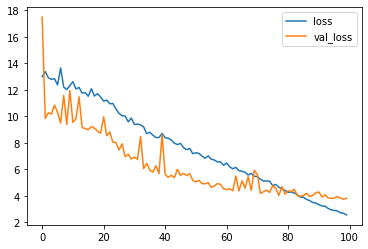

In [68]:
# plot the loss and accuracy
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


In [69]:
# save the model
model.save('model.h5')

In [70]:
# load the model
model = keras.models.load_model('model.h5')
